In [1]:
import pandas as pd 
df = pd.read_csv("merged_medical_QA_dataset(2).csv")
documents = df[["question", "answer", "source"]].fillna("")

docs = [
    f"Q: {row['question']}\nA: {row['answer']}\nSource:{row['source']}"
    for _, row in df.iterrows() ]


In [2]:
from sentence_transformers import SentenceTransformer, CrossEncoder
import faiss #facebook AI similarity Search, search engine for vector similarity

embedding_model = SentenceTransformer("pritamdeka/BioBERT-mnli-snli-scinli-scitail-mednli-stsb")  # Biomedical embeddings ref ds favoris
# a specific embedding model trained on biomedical dataset

# Convert docs to vectors
embeddings = embedding_model.encode(docs, show_progress_bar=True)

# Create FAISS index
index = faiss.IndexFlatL2(embeddings.shape[1]) #calcul similarité avec la distance euclidienne
index.add(embeddings) 

Batches:   0%|          | 0/959 [00:00<?, ?it/s]

In [6]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

query = [
    "What are the symptoms of  breast cancer ?",
    "What should I do when I have a headache ?",
     "How does hypertension affect the heart?",
    "How can I see that I have skin cancer ?",
    "Is it safe to take paracetamol and ibuprofen together?",
    "What should I do if I experience chest pain ?",
    "What are the common symptoms of endometriosis?",
    "What are the signs of a seizure ?",
    "What are the best ways to manage chronic pain?",
    " I have a lump in my leg, What should I do?",
    "How to I know if I have food allergy?",
    "How long does it take to recover from a fractured tibia?",
    "What are the signs of a stroke?",
    "What are the early signs of pregnancy?",
    " Is an acute headache a symptom of brain cancer?",

    "Is ice effective for a sprained ankle ?",
    "How can I ease my period pain ?",
    "There is a black dot in my vision. Do I have eye cancer ?",
    " There is a yellow dot in my left eye. What it is ?",
    "I have a lump in my neck, should I be worried?",
    "At what age should a baby drink water?",
    "Why my heart and my left arm hurts ?",
    "Why does hurt when I pee?",
    "What causes intermittent headaches?",

    

    "What are the recommended guidelines for gestational diabetes screening and management?", #OK
    "How does hypertension contribute to the development of atrial fibrillation?",
    "How can we differentiate between essential tremor and Parkinson’s disease?",#OK
    "What are the indications for emergency C-section in labor?",#OK
    "How can we differentiate between bacterial and viral meningitis based on clinical and laboratory findings?",
    "How can we differentiate between an ischemic and a hemorrhagic stroke based on clinical presentation?",
    "What are the hemodynamic effects of propofol versus etomidate in induction of anesthesia?",
]
query_embedding = embedding_model.encode(query,show_progress_bar=True) #applique embedding sur les questions

# Search top 3 similar docs
_, indices = index.search(query_embedding, k=10) #it was 3 before

#:::::::::::::::::::::::: sans scores de similarité /::::::::::::::::::
# Retrieve top docs
# retrieved_docs = []
# retrieved_sources=[]

# for i, ind_list in enumerate(indices): #parcour les vectors similaire au query
#     context = "\n".join(([f"Q: {df.iloc[j]['question']}\nA: {df.iloc[j]['answer']}" for j in ind_list])) #
#     sources= list(set([df.iloc[j]['source'] for j in ind_list])) 
#     retrieved_docs.append(context) #ajout les infos pertinentes dans une liste
#     retrieved_sources.append(sources)

#////////////// avec scores de similarité /////////////////////
# retrieved_docs = []
# retrieved_sources = []
# retrieved_scores = []

# for i, (ind_list, dist_list) in enumerate(zip(indices, _)):
#     doc_chunks = []
#     score_chunks = []
#     for j, dist in zip(ind_list, dist_list):
#         sim_score = 1 / (1 + dist)
#         doc_chunks.append(f"Q: {df.iloc[j]['question']}\nA: {df.iloc[j]['answer']}\n[Score: {sim_score:.4f}]")
#         score_chunks.append(sim_score)
#     context = "\n".join(doc_chunks)
#     sources = list(set([df.iloc[j]['source'] for j in ind_list]))
    
#     retrieved_docs.append(context)
#     retrieved_sources.append(sources)
#     retrieved_scores.append(score_chunks)

#/////////////////////// avec reranker /////////////////
reranker = CrossEncoder("cross-encoder/ms-marco-MiniLM-L-6-v2")

retrieved_docs = []
retrieved_sources = []
retrieved_scores= []

for i, ind_list in enumerate(indices):
    query_text = query[i]
    
    # Créer les paires (query, doc)
    rerank_input = [(query_text, df.iloc[j]["answer"]) for j in ind_list]
    
    # Appliquer le reranker
    scores = reranker.predict(rerank_input)
    
    # Trier les documents par score décroissant
    reranked = sorted(zip(scores, ind_list), reverse=True)[:3]  # top 3
    
    # Reconstituer le contexte et les sources
    context = "\n".join(
        [f"Q: {df.iloc[j]['question']}\nA: {df.iloc[j]['answer']}" for _, j in reranked]
    )
    sources = list(set([df.iloc[j]["source"] for _, j in reranked]))
    top_scores = [score for score, _ in reranked] 
    scaler = MinMaxScaler()
    top_scores_array = np.array(top_scores).reshape(-1, 1)
    normalized_scores = scaler.fit_transform(top_scores_array).flatten()

    retrieved_docs.append(context)
    retrieved_sources.append(sources)
    retrieved_scores.append(normalized_scores)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

[array([1.      , 0.718555, 0.      ], dtype=float32), array([1.       , 0.0288555, 0.       ], dtype=float32), array([1.        , 0.70369124, 0.        ], dtype=float32), array([1.        , 0.38716334, 0.        ], dtype=float32), array([1.       , 0.1484223, 0.       ], dtype=float32), array([1.       , 0.5311546, 0.       ], dtype=float32), array([1.       , 0.8135248, 0.       ], dtype=float32), array([1.       , 0.3963539, 0.       ], dtype=float32), array([1.        , 0.11725491, 0.        ], dtype=float32), array([1.0000005 , 0.08399773, 0.        ], dtype=float32), array([1.        , 0.04693702, 0.        ], dtype=float32), array([1.       , 0.6422138, 0.       ], dtype=float32), array([1.       , 0.7324152, 0.       ], dtype=float32), array([1.       , 0.5029005, 0.       ], dtype=float32), array([1.        , 0.11062193, 0.        ], dtype=float32), array([1.      , 0.341259, 0.      ], dtype=float32), array([0.9999999 , 0.96440613, 0.        ], dtype=float32), array([1.      

In [7]:
import torch
from transformers import AutoTokenizer, BioGptForCausalLM
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

prompts = [f"{retrieved_docs[i]}\n\nQuestion:{query[i]}\n\nAnswer:"
for i in range(len(query))] 
#prompt pr chaque query contenant 
#1. l'info pertinente (question et réponse ds le dataset medquad)
#2. la question posé
#Answer: (vide)


tokenizer = AutoTokenizer.from_pretrained("microsoft/biogpt-large")
biogpt = BioGptForCausalLM.from_pretrained("microsoft/biogpt-large").to(device)

answers=[]
for prompt in prompts:
    inputs = tokenizer(prompt, return_tensors="pt", max_length=1024, truncation=True).to(device)
    outputs = biogpt.generate(**inputs, max_new_tokens=128)
    answer= tokenizer.decode(outputs[0], skip_special_tokens=True)#retour en format str
    answers.append(answer)
    
# for i,(q,a) in enumerate(zip(query, answers)):
#     sources=",".join(retrieved_sources[i])
#     print(f"\n question: {q}\n Answer: {a}\n Reference:{sources}\n{'='*50}")


for i, (q, a) in enumerate(zip(query, answers)):
    sources = ",".join(retrieved_sources[i])
    print(f"\nQuestion: {q}\nAnswer: {a}\nSources: {sources}")
    print("Relevance Scores :")
    for score in retrieved_scores[i]:
        print(f"- {score:.4f}")
    print("=" * 50)




Question: What are the symptoms of  breast cancer ?
Answer: Q: What are the symptoms of Breast Cancer? A: Signs of breast cancer include a lump or change in the breast. These and other signs may be caused by breast cancer or by other conditions. Check with your doctor if you have any of the following: - A lump or thickening in or near the breast or in the underarm area. - A change in the size or shape of the breast. - A dimple or puckering in the skin of the breast. - A nipple turned inward into the breast. - Fluid, other than breast milk, from the nipple, especially if it's bloody. - Scaly, red, or swollen skin on the breast, nipple, or areola (the dark area of skin around the nipple). - Dimples in the breast that look like the skin of an orange, called peau dorange. Q: What are the symptoms of Breast Cancer? A: When breast cancer first develops, there may be no symptoms at all. But as the cancer grows, it can cause changes that women should watch for. You can help safeguard your hea

In [6]:
import json
tout2=[]
for q,r in zip(query,answers):
    data_json_biogpt_RAG = {"question": q, "answer": r}
    tout2.append(data_json_biogpt_RAG)
with open("biogpt_RAG_resultat3.json", "w", encoding="utf-8") as f:
           json.dump(tout2, f, ensure_ascii=False, indent=4) 

In [9]:
import json

# Chargement des fichiers JSON (exemple)
with open("biogpt_RAG_resultat3.json", 'r', encoding='utf-8') as f:
    premier = json.load(f)

with open('biogpt_RAG_resultat2.json', 'r', encoding='utf-8') as f:
    deuxieme = json.load(f)

# Supposons que chaque item dans deuxieme correspond à l'item dans premier par index
for i in range(len(deuxieme)):
    # Chercher la clé 'cognitive bias' dans l'item correspondant de premier
    if 'cognitive bias' in premier[i]:
        deuxieme[i]['cognitive bias'] = premier[i]['cognitive bias']

# Sauvegarder le résultat modifié dans un nouveau fichier
with open('deuxieme_modifie.json', 'w', encoding='utf-8') as f:
    json.dump(deuxieme, f, indent=4, ensure_ascii=False)


Counter({'omission bias': 11, 'Correct': 9, 'Out of topic': 5, 'overconfidence bias': 3, 'False': 3, 'confirmation  bias': 0})


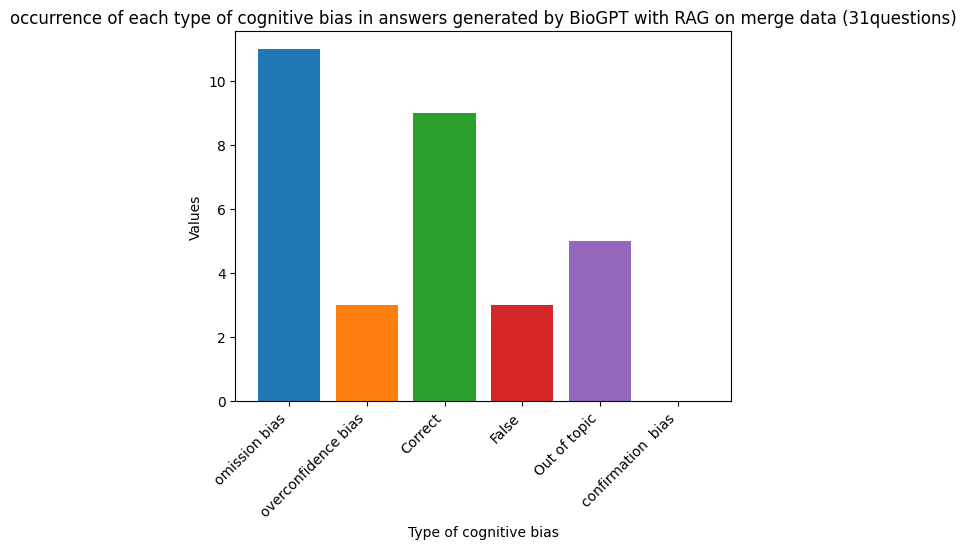

In [2]:
#analyzing the proportion of cognitive bias after RAG on merge data

import json
from collections import Counter
import matplotlib.pyplot as plt

bias=[]
with open("biogpt_RAG_resultat_mergeData.json", "r", encoding="utf-8") as f:
    file_j= json.load(f)
    
for dico in file_j:
    bias.append(dico["cognitive bias"])
    
freq = Counter(bias)
freq.update({"confirmation  bias": 0 })
print(freq)
labels = list(freq.keys())
val = [freq[label] for label in labels]


plt.bar(labels, val, color=plt.cm.tab10.colors[:len(labels)])


plt.xlabel("Type of cognitive bias")
plt.ylabel("Values")
plt.title("occurrence of each type of cognitive bias in answers generated by BioGPT with RAG on merge data (31questions)")
plt.xticks(rotation=45, ha='right')
plt.savefig("proportion_of_cognitive_bias_for_BioGPT_RAG_merge_data(31_questions).jpg")
plt.show()